In [1]:
import optuna
import random
import math
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.problem_loaders.vrp_loader import VRPLoader
from src.algorithms.ga_vrp import GeneticAltorithmVRP
from src.algorithms.ant_system import AntSystem
from src.algorithms.ant_vrp import AntVRP
from src.plotting import plot_solution

# VRP with GA

In [3]:
PROBLEM_INSTANCE_NAME = 'B-n31-k5'

vrp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = vrp_loader.load_problem_instance()
ga_trials = []
def objective(trial):
    params = {
        "mutation_rate" : trial.suggest_float("mutation_rate", 0.01, 0.9),
        "population_size" : trial.suggest_int("population_size", 10,60),
        "elitism_rate" : trial.suggest_float("elitism_rate", 0.01, 0.2),
        "max_generations" : trial.suggest_int("max_generations", 50, 400)
    }
    ga = GeneticAltorithmVRP(problem_instance, coordinates, demand, capacity, **params)
    ga_trials.append(ga)
    ga.run(trial)

    return np.min(ga.best_fitness_in_generation)

study = optuna.create_study(study_name=f"ga_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///ga_{PROBLEM_INSTANCE_NAME}.db", load_if_exists=True, direction="minimize")
study.optimize(objective, n_trials=50)

[I 2022-11-27 10:07:11,875] A new study created in RDB with name: ga_B-n31-k5
Generation: 100%|██████████| 322/322 [05:05<00:00,  1.05it/s]
[I 2022-11-27 10:12:18,486] Trial 0 finished with value: 704.995863950082 and parameters: {'mutation_rate': 0.7123139543915628, 'population_size': 25, 'elitism_rate': 0.05898102737443605, 'max_generations': 322}. Best is trial 0 with value: 704.995863950082.
Generation: 100%|██████████| 230/230 [02:03<00:00,  1.87it/s]
[I 2022-11-27 10:14:22,129] Trial 1 finished with value: 697.9589294041624 and parameters: {'mutation_rate': 0.34335212565522555, 'population_size': 26, 'elitism_rate': 0.04838431845595044, 'max_generations': 230}. Best is trial 1 with value: 697.9589294041624.
Generation: 100%|██████████| 136/136 [01:19<00:00,  1.70it/s]
[I 2022-11-27 10:15:42,664] Trial 2 finished with value: 689.9482475875159 and parameters: {'mutation_rate': 0.5800417593436712, 'population_size': 23, 'elitism_rate': 0.13408255731237653, 'max_generations': 136}. B

## Plot feature importance

In [3]:
PROBLEM_INSTANCE_NAME = 'B-n31-k5'
study = optuna.load_study(study_name=f"ga_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///ga_{PROBLEM_INSTANCE_NAME}.db")


fig = optuna.visualization.plot_param_importances(study)
fig.write_image(f"./plots/vrp/ga_feature_importance.pdf")
fig.write_image(f"./plots/vrp/ga_feature_importance.png")
fig

## Plot trials

C:\Users\karst\AppData\Local\Temp\ipykernel_10944\1453091512.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:53: RuntimeWarning: invalid value encountered in divide
  unit_delta_x = delta_x / delta_length
d:\Code\Python\Uni\Self-Organizing_Systems\exercise_1\src\plotting.py:54: RuntimeWarning: invalid value encountered in divide
  unit_delta_y = delta_y / delta_length
C:\Users\karst\AppData\Local\Temp\ipykernel_10944\1453091512.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\karst\AppData\Local\Temp\ipykernel_10944\1453091512.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:

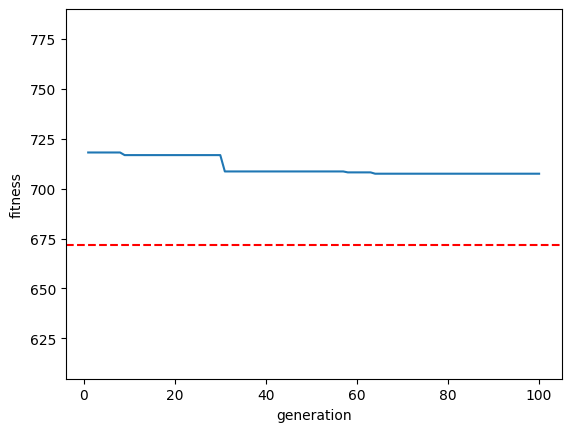

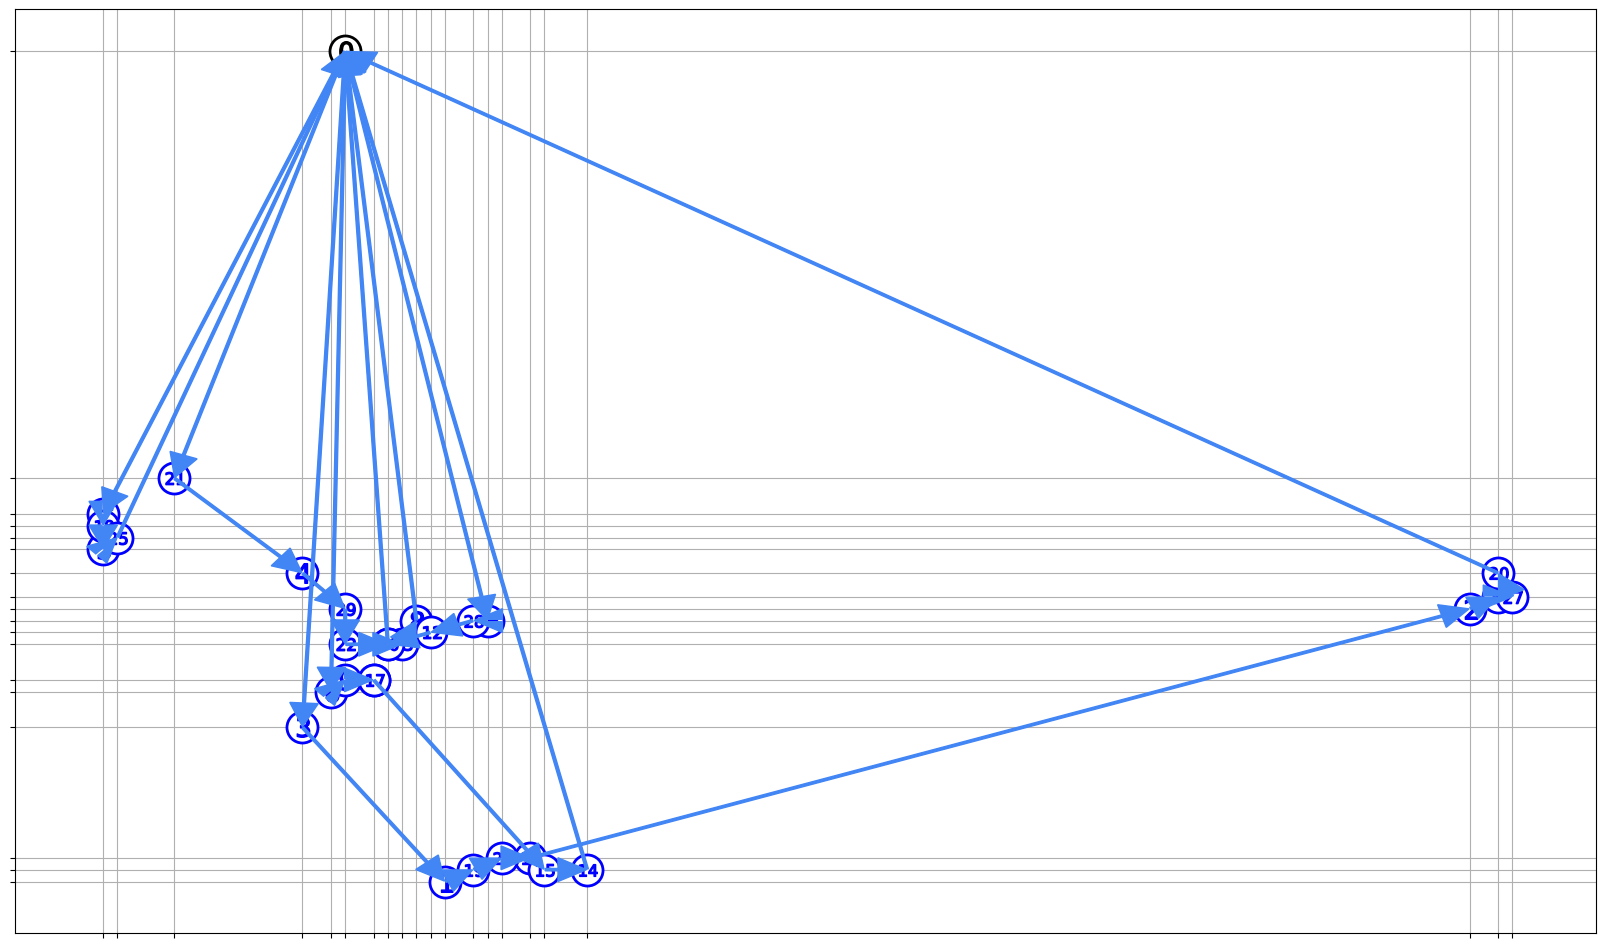

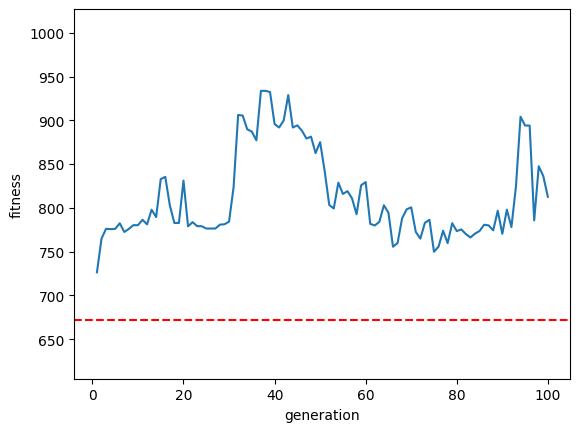

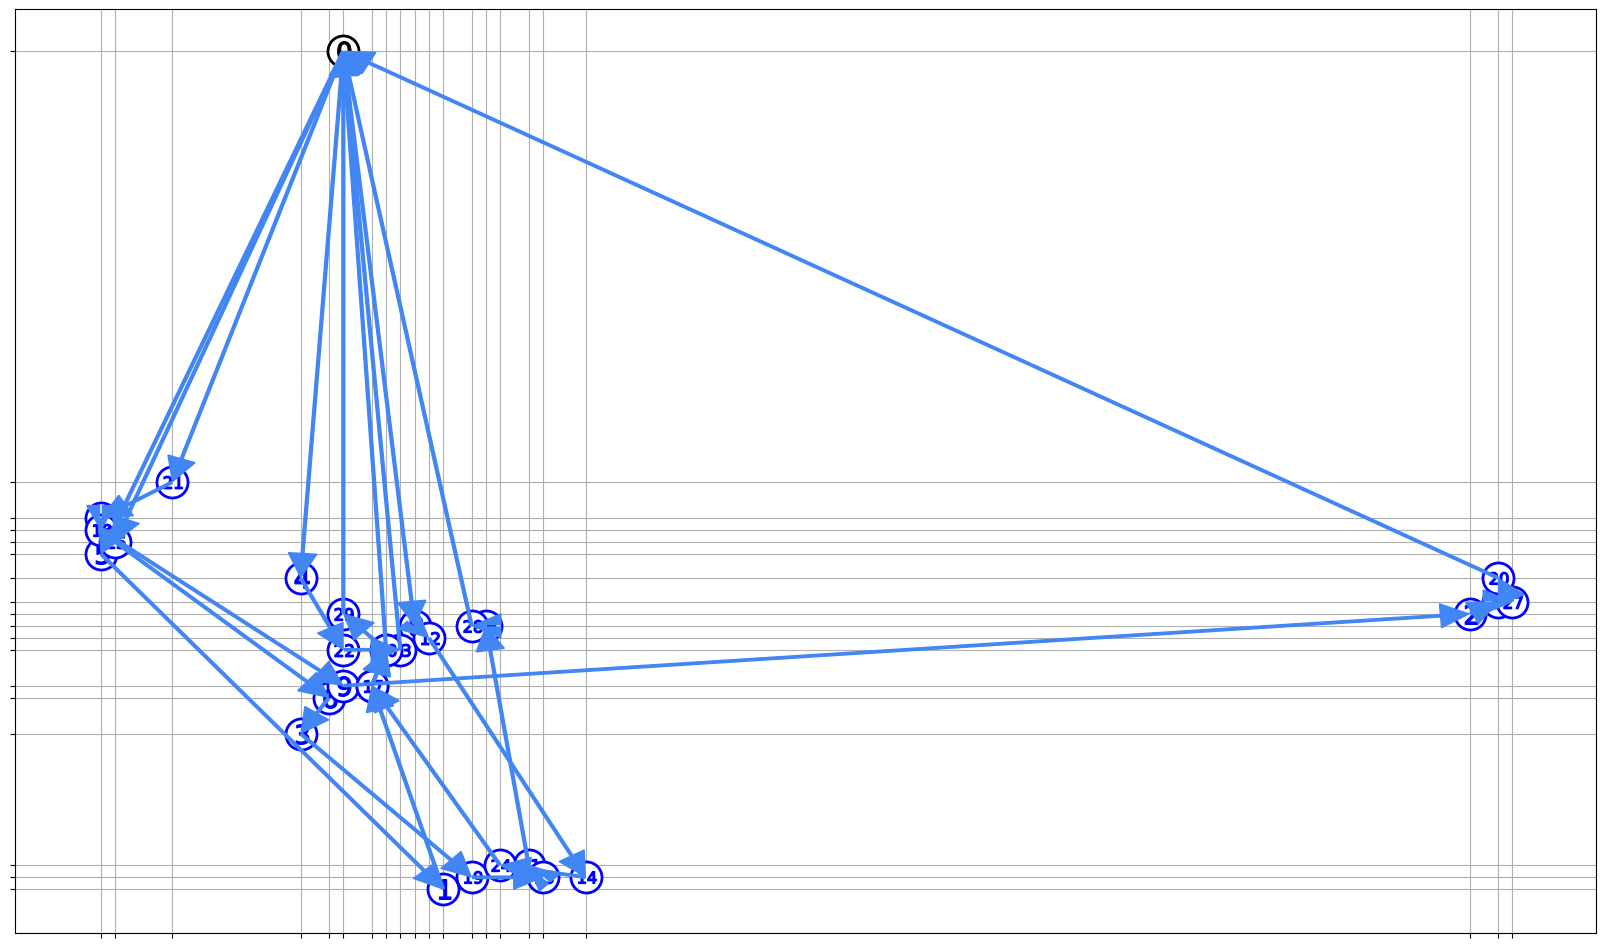

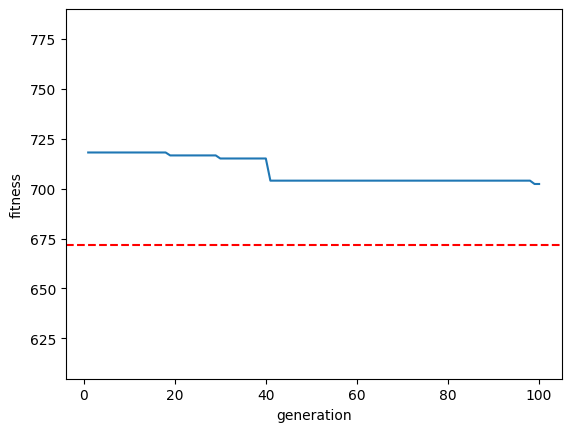

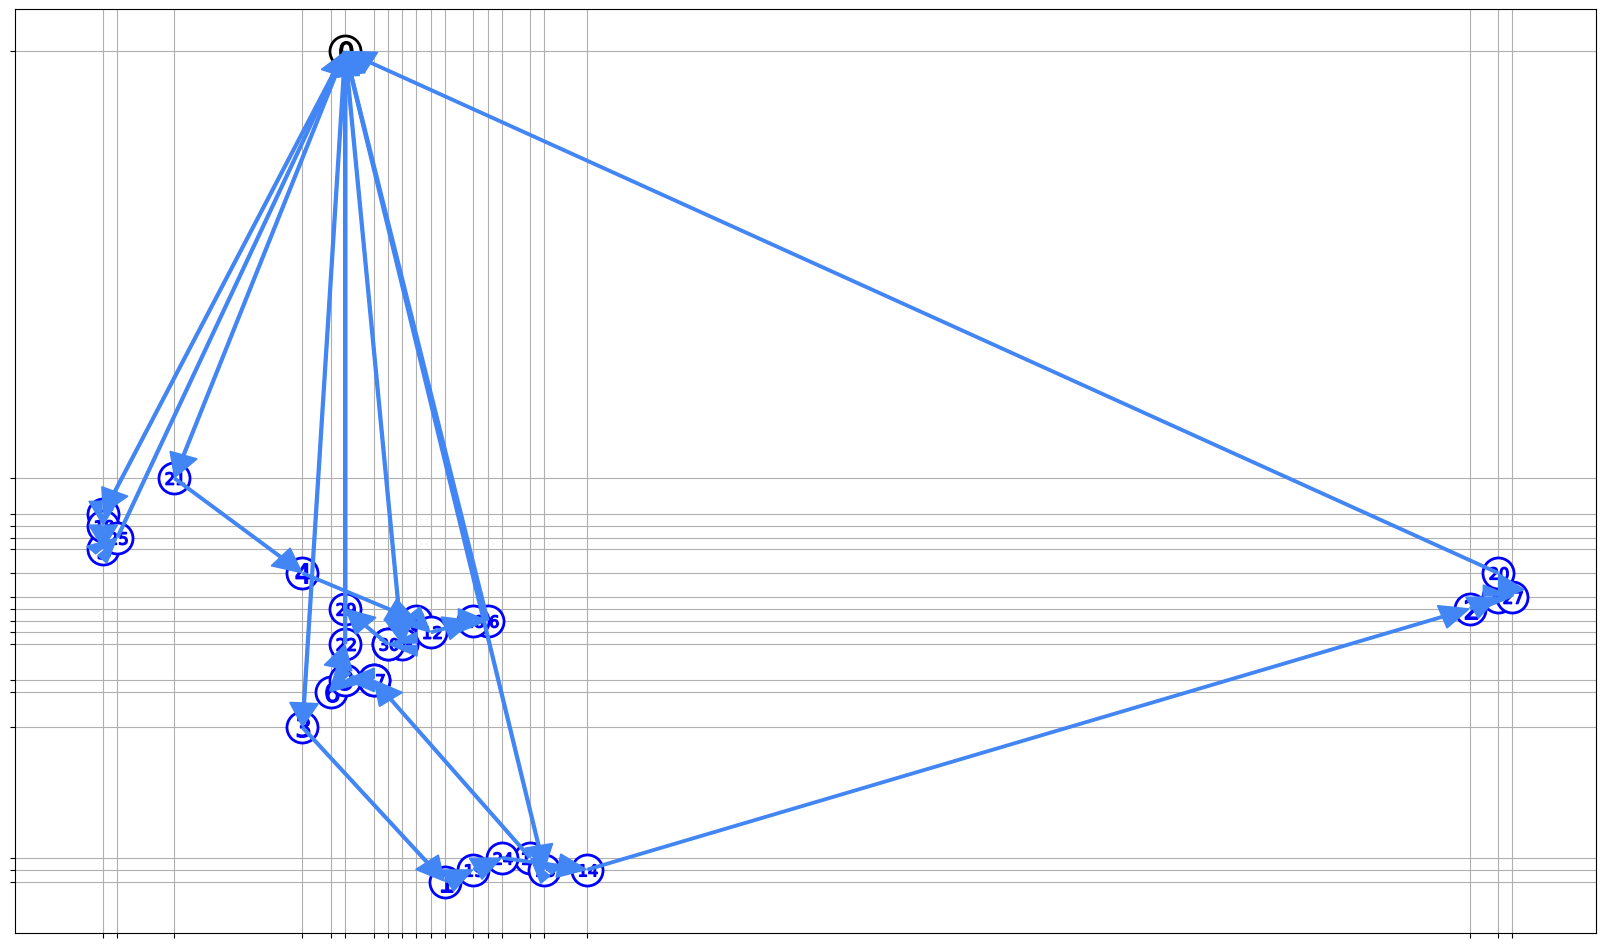

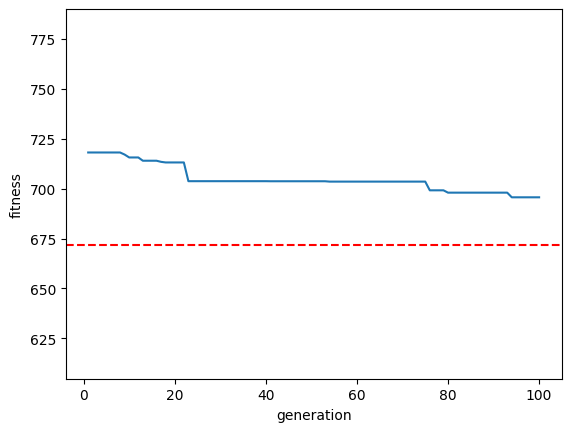

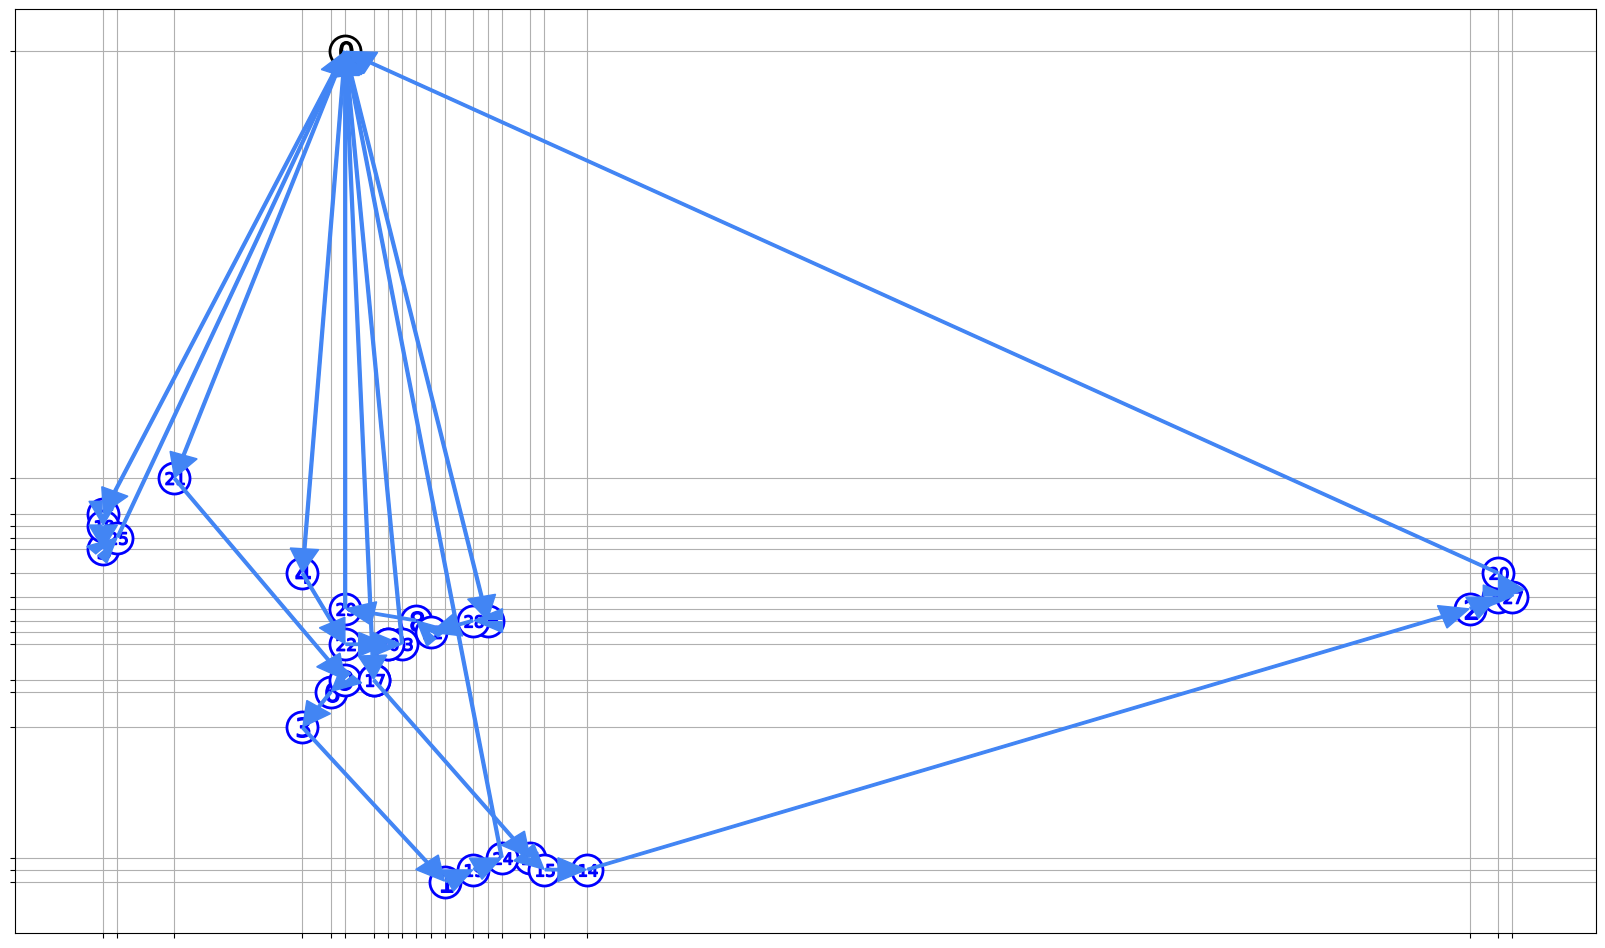

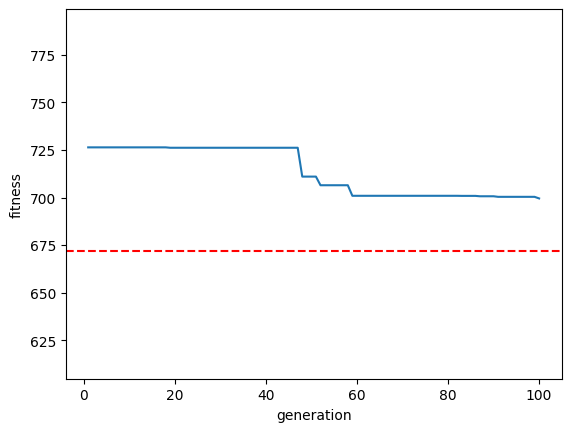

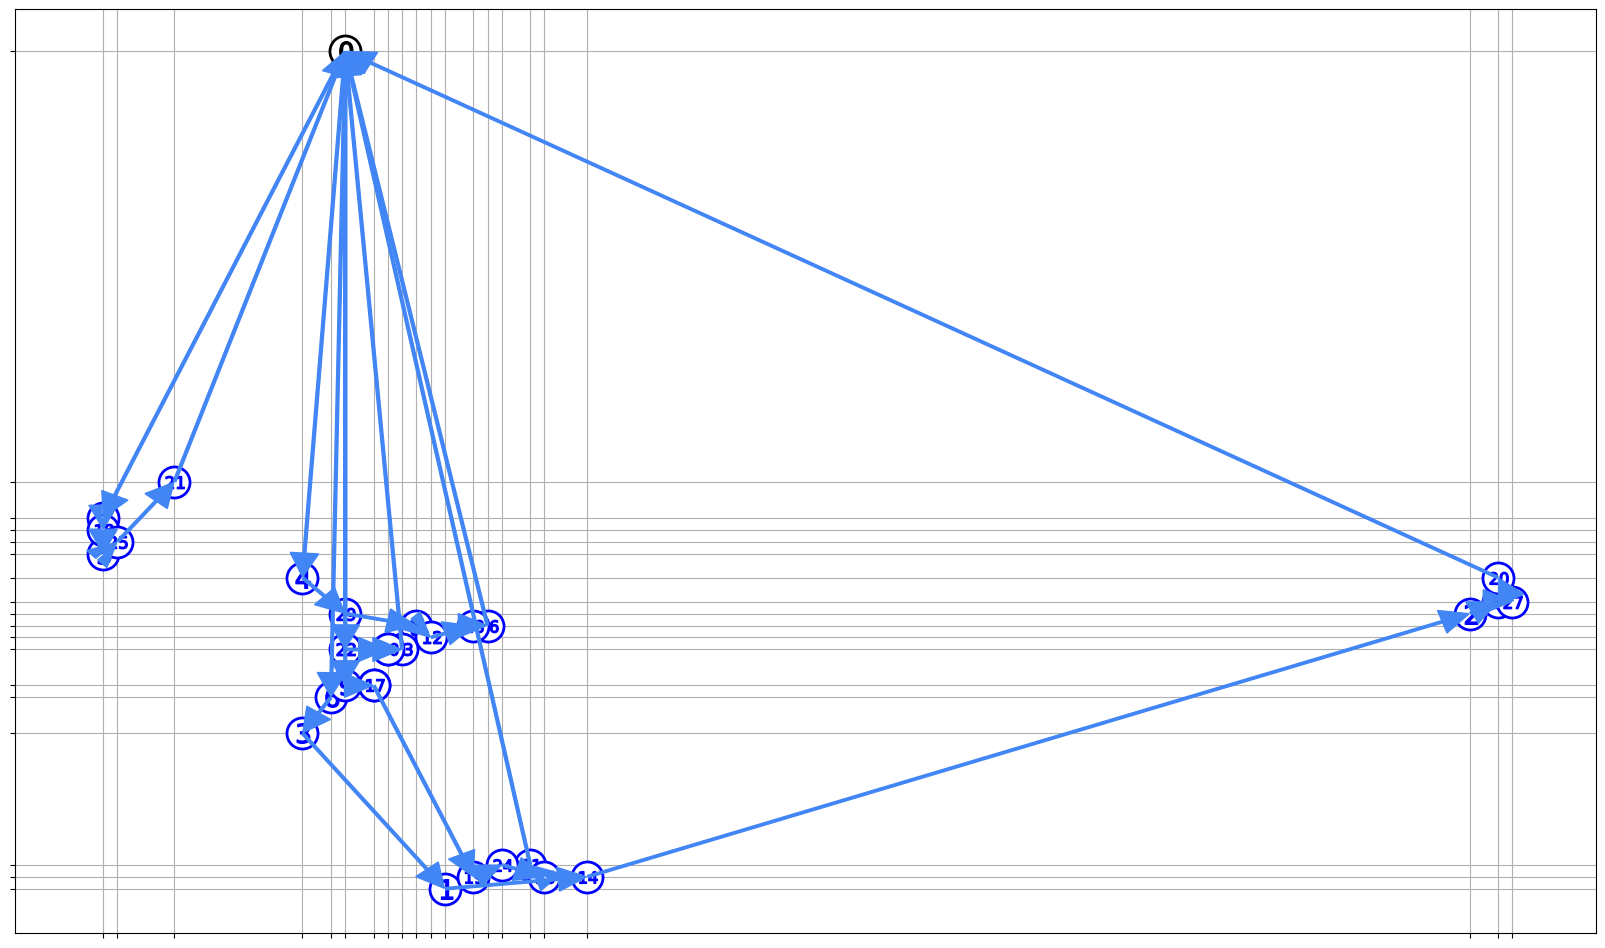

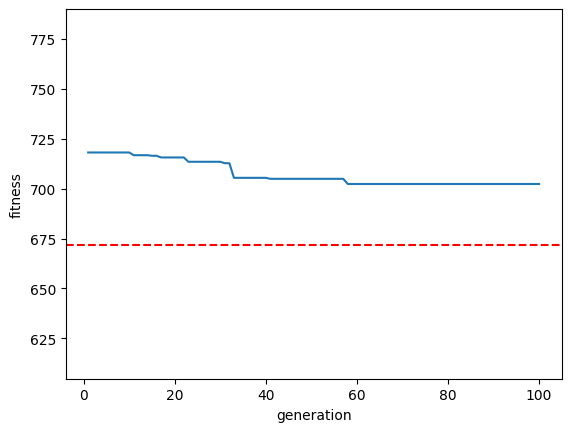

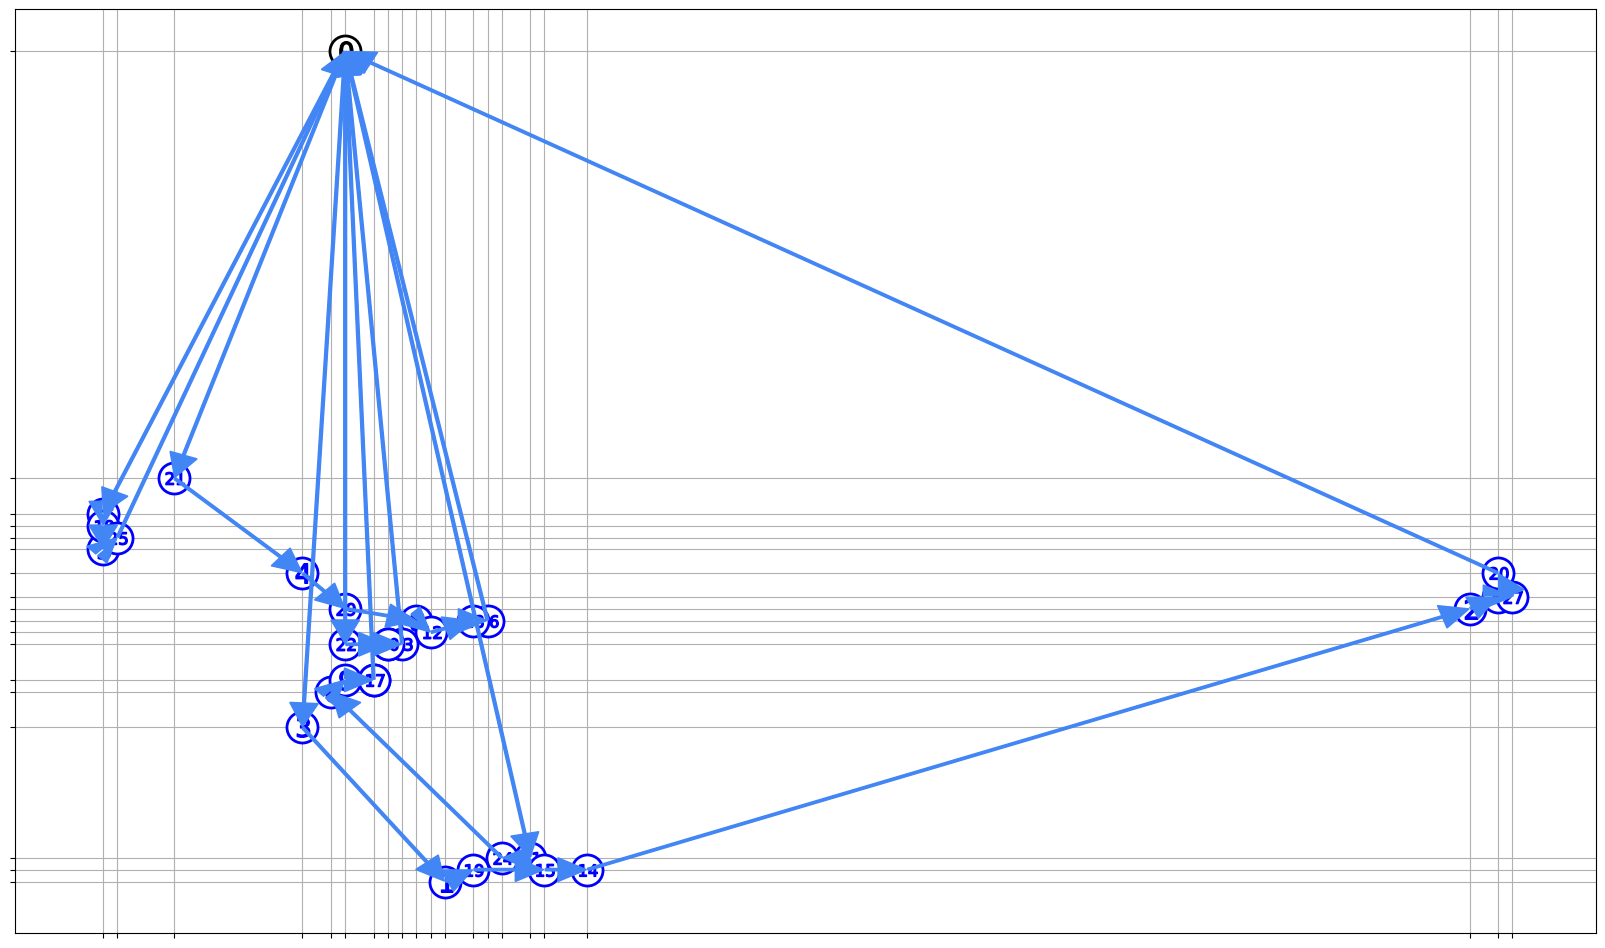

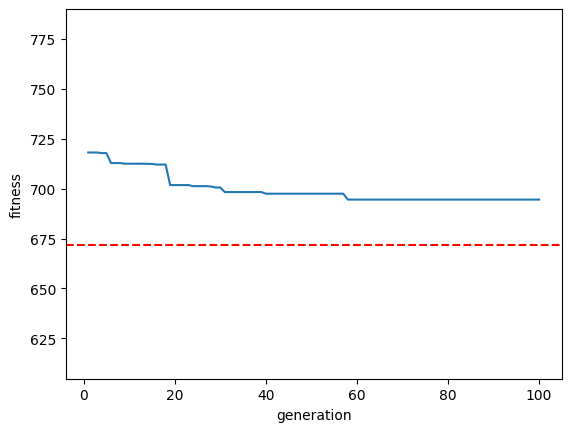

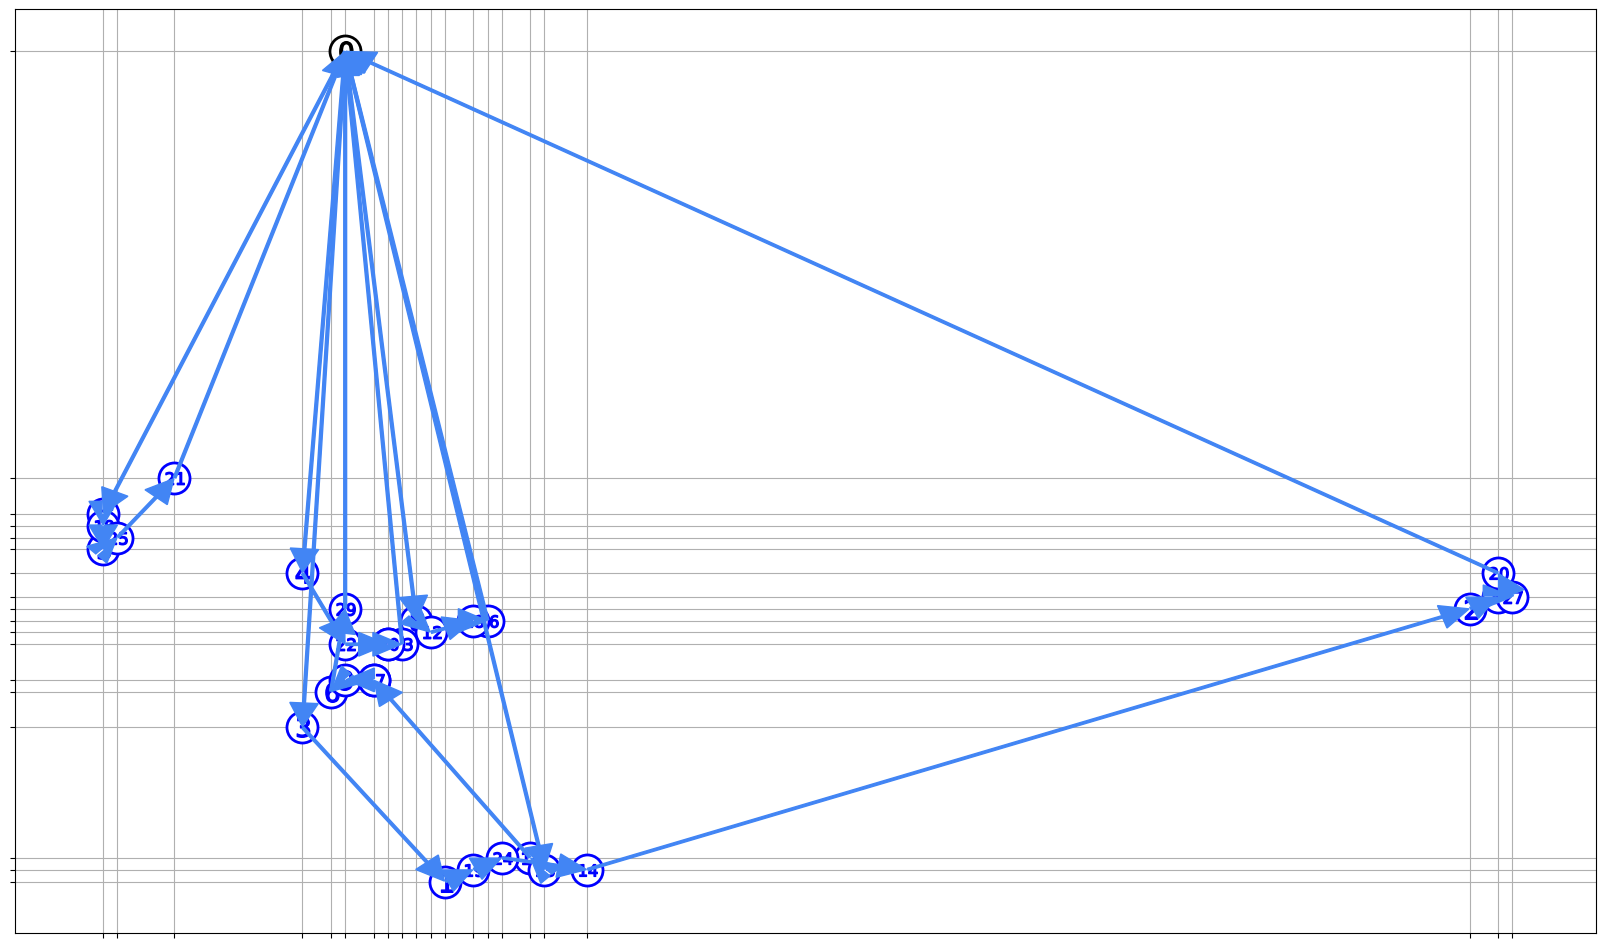

In [16]:
for trial, ga in enumerate(ga_trials):
    if study.get_trials()[trial].state == optuna.trial.TrialState.PRUNED:
        continue
   
    # plot training
    stats_df = ga.fitness_df()
    fig, ax = plt.subplots()
    chart = sns.lineplot(data=stats_df, x='generation', y='fitness', ax=ax)
    ax.set_ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(best_solution_cost, color='red', linestyle='--')
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}.pdf")
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}.png")
    fig.show()

    # plot paths
    best_path = ga._get_paths(ga.best_chromosome.chromosome)[0]
    single_path = list(itertools.chain.from_iterable(best_path)) + [0]
    fig = plot_solution(coordinates, single_path)
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}_path.pdf")
    fig.savefig(f"./plots/vrp/vrp_ga_{trial}_path.png")
    fig.show()
    

# VRP with Ant System

In [18]:
PROBLEM_INSTANCE_NAME = 'X-n655-k131' #"tai100a"# #'B-n31-k5'#

vrp_loader = VRPLoader(PROBLEM_INSTANCE_NAME)
coordinates, problem_instance, demand, capacity, best_solution, best_solution_cost = vrp_loader.load_problem_instance()

as_trials = []
def as_objective(trial):
    params = {
        "number_of_ants" : trial.suggest_int("number_of_ants", 5, 200),
        "time" : trial.suggest_int("time", 20, 100),
        "visibility" : trial.suggest_categorical("visibility", ["distance", "saving_function"]),
        "trail_update" : trial.suggest_categorical("trail_update", ["all", "best", "elitist"]),
        "alpha" : trial.suggest_int("alpha", 1, 6),
        "beta" : trial.suggest_int("beta", 1,6),
        "evaporation_coefficient" : trial.suggest_float("evaporation_coefficient", 0.01, 0.9),
        "best_rate" : trial.suggest_float("best_rate", 0.05, 0.5),
        "candidate_ratio" : trial.suggest_float("candidate_ratio", 0.1, 1)
    }
    ant_system = AntSystem(AntVRP, problem_instance, demand=demand, capacity=capacity, debug_mode=False, **params)
    as_trials.append(ant_system)
    try:
        ant_system.run(trial)
        return np.min(ant_system.best_fitness_at_time_point)
    except ValueError:
        raise optuna.TrialPruned()

as_study = optuna.create_study(study_name=f"as_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///as_{PROBLEM_INSTANCE_NAME}.db", load_if_exists=True, direction="minimize")




[I 2022-11-27 13:43:16,257] A new study created in RDB with name: as_X-n655-k131


In [19]:
as_study.optimize(as_objective, n_trials=10)

Time Point: 100%|██████████| 71/71 [18:58<00:00, 16.04s/it]
[I 2022-11-27 14:02:15,448] Trial 0 finished with value: 113786.8843923946 and parameters: {'number_of_ants': 159, 'time': 71, 'visibility': 'distance', 'trail_update': 'elitist', 'alpha': 3, 'beta': 3, 'evaporation_coefficient': 0.18036161906164133, 'best_rate': 0.26624298235717436, 'candidate_ratio': 0.75112528030838}. Best is trial 0 with value: 113786.8843923946.
Time Point: 100%|██████████| 72/72 [15:01<00:00, 12.52s/it]
[I 2022-11-27 14:17:17,290] Trial 1 finished with value: 157916.2283797943 and parameters: {'number_of_ants': 85, 'time': 72, 'visibility': 'saving_function', 'trail_update': 'all', 'alpha': 2, 'beta': 3, 'evaporation_coefficient': 0.33338093171726213, 'best_rate': 0.4203115710026188, 'candidate_ratio': 0.17111072261800525}. Best is trial 0 with value: 113786.8843923946.
Time Point: 100%|██████████| 80/80 [15:57<00:00, 11.97s/it]
[I 2022-11-27 14:33:15,270] Trial 2 finished with value: 145656.25588034335 

KeyboardInterrupt: 

## Plot trials

/tmp/ipykernel_89155/3471207544.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

/home/ruzickal/Code/Uni/Self-Organizing_Systems/exercise_1/src/plotting.py:53: RuntimeWarning:

invalid value encountered in divide

/home/ruzickal/Code/Uni/Self-Organizing_Systems/exercise_1/src/plotting.py:54: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_89155/3471207544.py:26: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

/tmp/ipykernel_89155/3471207544.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.

/home/ruzickal/Code/Uni/Self-Organizing_Systems/exercise_1/src/plotting.py:53: RuntimeWarning:

invalid value encountered in divide

/home/ruzickal/Code/Uni/Self-Organizing_Systems/exercis

Error in Trial 4


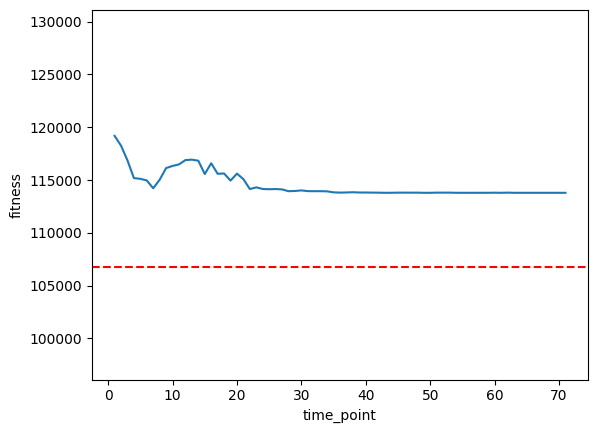

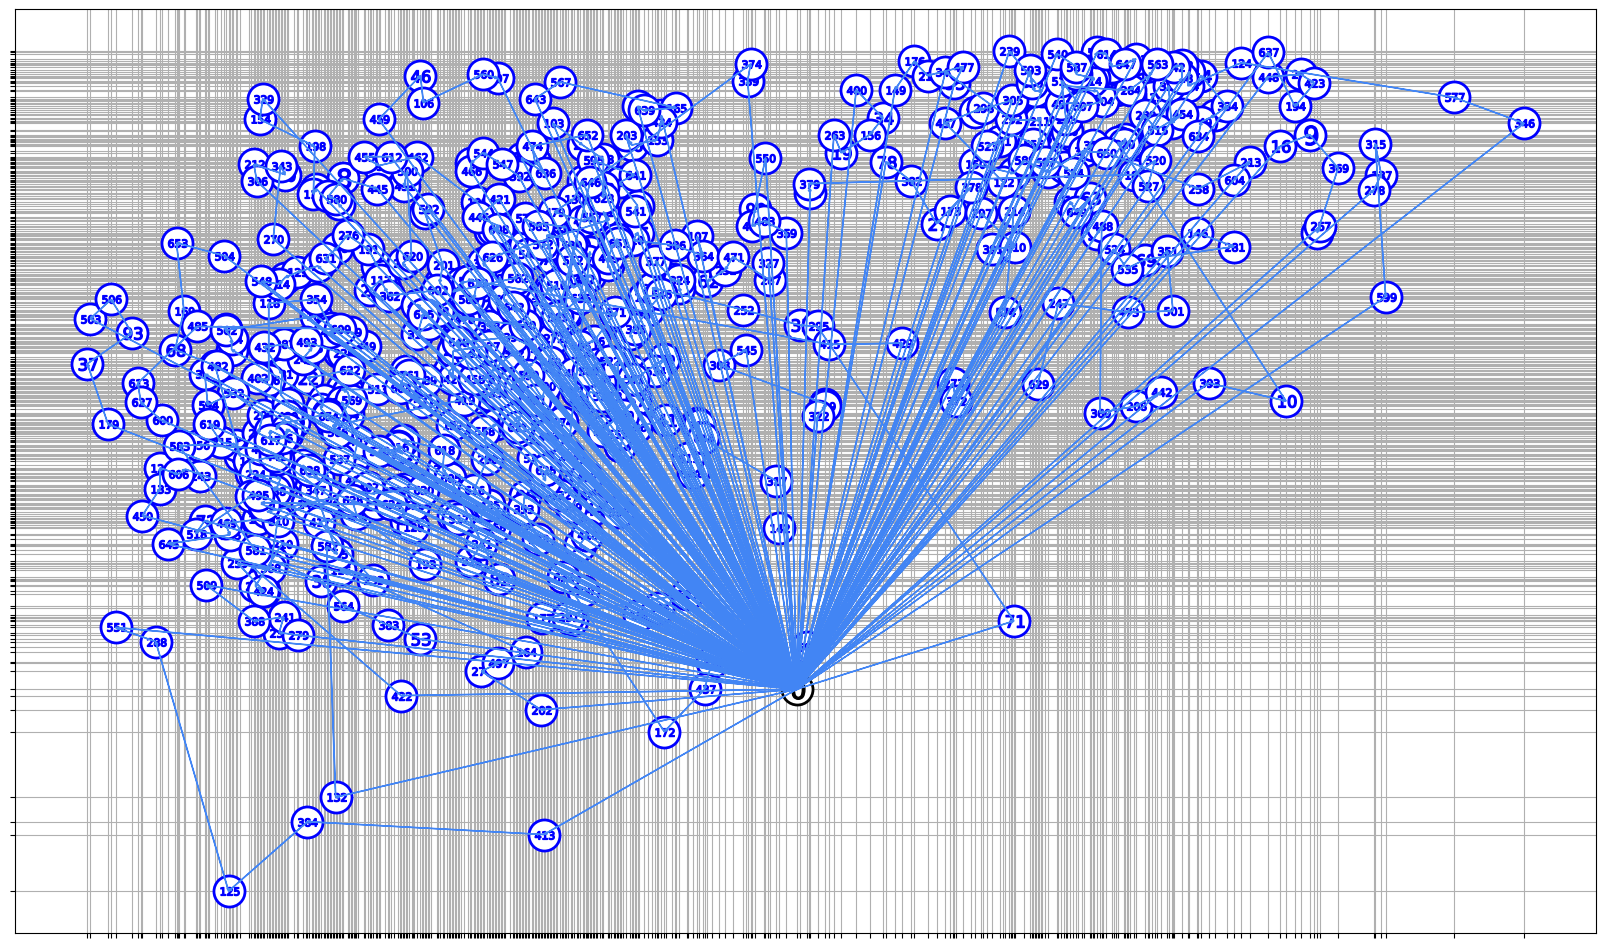

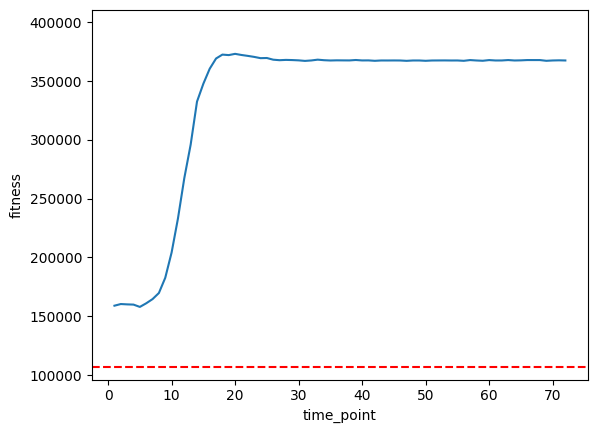

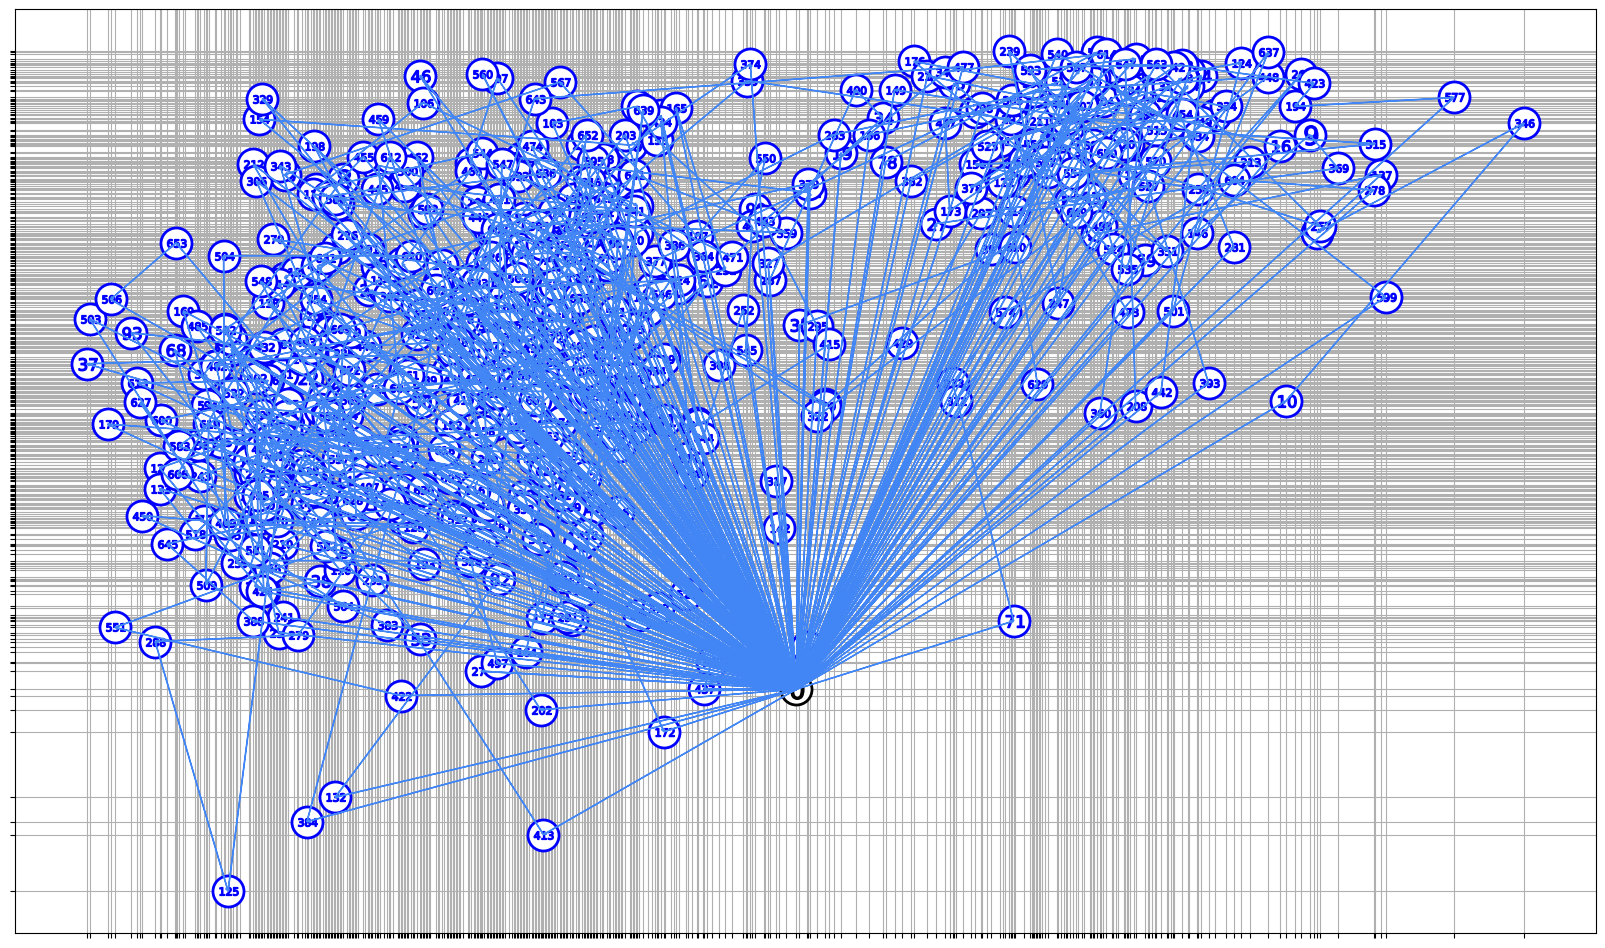

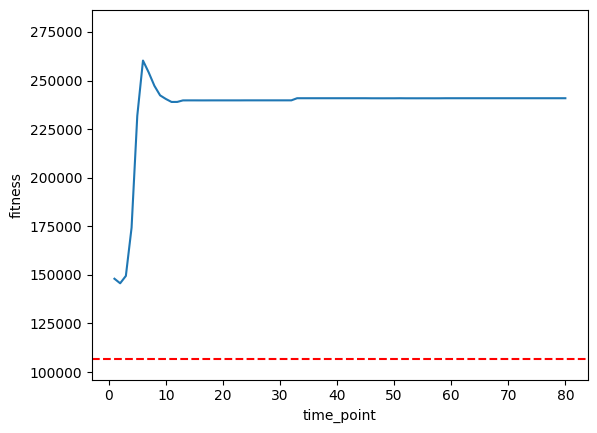

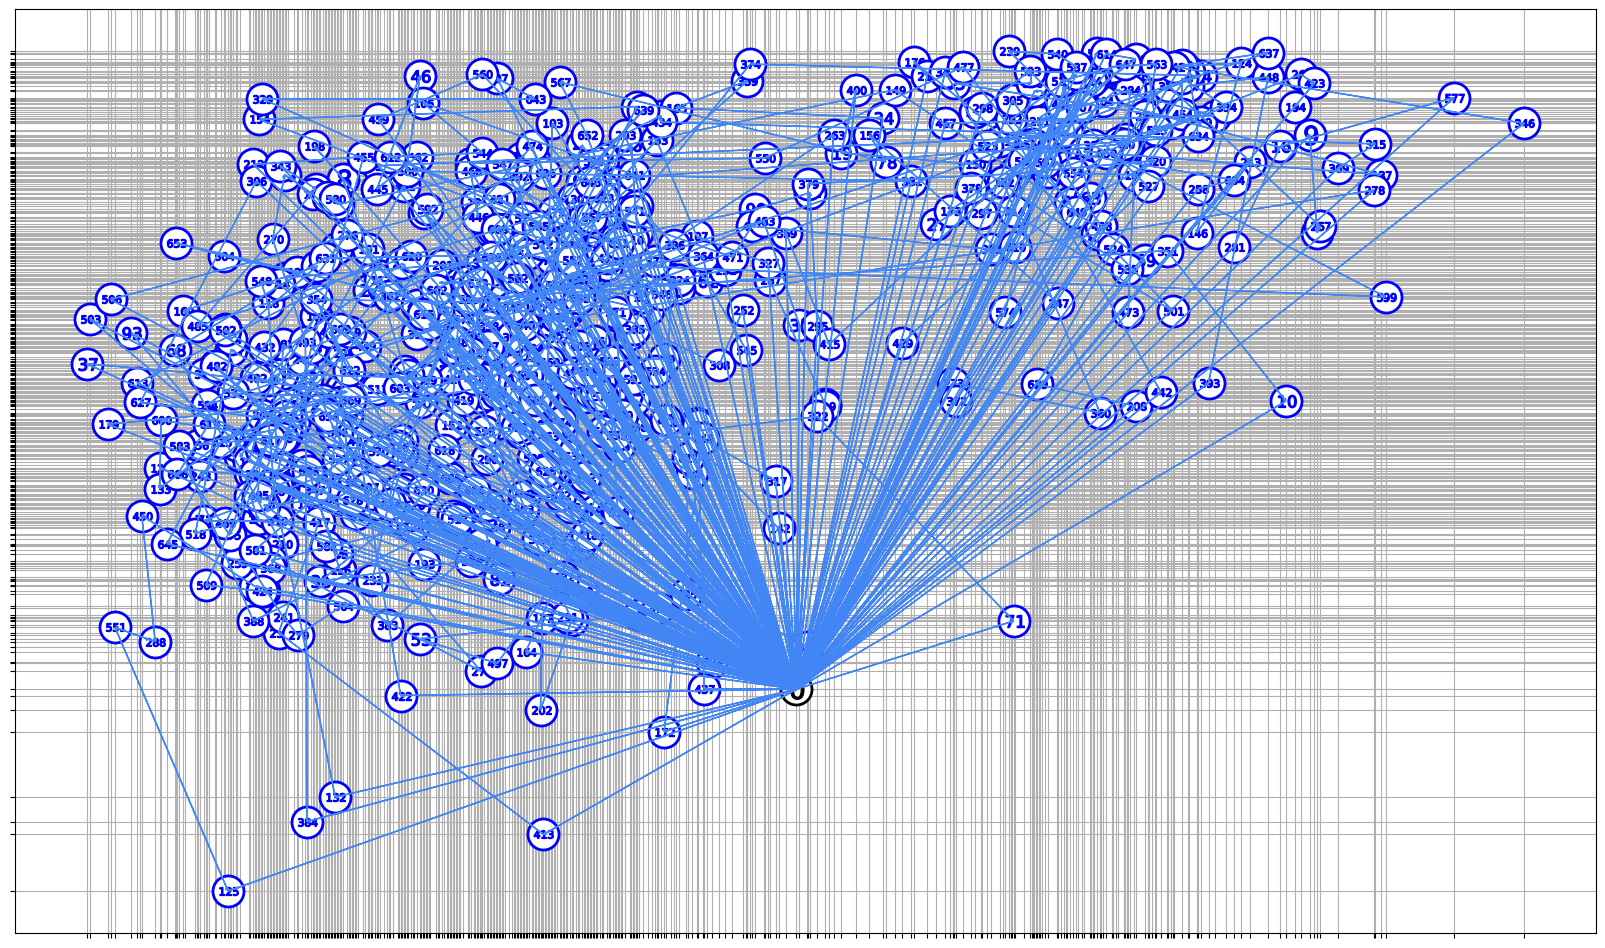

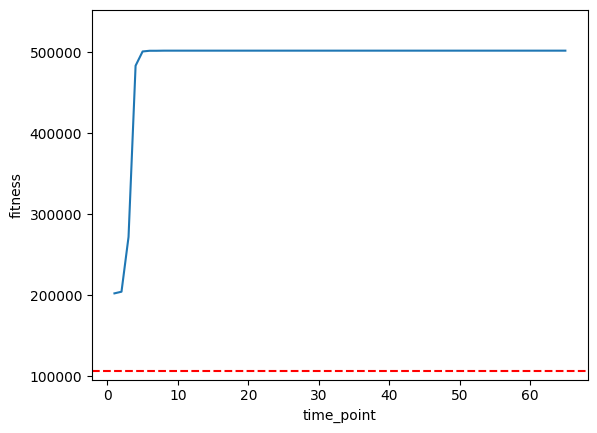

Error in callback <function flush_figures at 0x7fc5f5ccc940> (for post_execute):


KeyboardInterrupt: 

In [20]:
for trial, ant_system in enumerate(as_trials):
    if as_study.get_trials()[trial].state == optuna.trial.TrialState.PRUNED:
        continue
   
    # plot training
    try:
        stats_df = ant_system.fitness_df()
    except ValueError:
        print(f"Error in Trial {trial}")
        continue
    
    fig, ax = plt.subplots()
    chart = sns.lineplot(data=stats_df, x='time_point', y='fitness', ax=ax)
    ax.set_ylim(best_solution_cost * 0.9, stats_df.fitness.max() * 1.1)
    chart.axhline(best_solution_cost, color='red', linestyle='--')
    fig.savefig(f"./plots/vrp/vrp_as_{PROBLEM_INSTANCE_NAME}_{trial}.pdf")
    fig.savefig(f"./plots/vrp/vrp_as_{PROBLEM_INSTANCE_NAME}_{trial}.png")
    fig.show()

    # plot paths
    best_path = ant_system.best_path
    single_path = best_path + [0]
    fig = plot_solution(coordinates, single_path)
    fig.savefig(f"./plots/vrp/vrp_as_{PROBLEM_INSTANCE_NAME}_{trial}_path.pdf")
    fig.savefig(f"./plots/vrp/vrp_as_{PROBLEM_INSTANCE_NAME}_{trial}_path.png")
    fig.show()

## Plot feature importance

In [11]:
PROBLEM_INSTANCE_NAME = 'B-n31-k5'
as_study = optuna.load_study(study_name=f"as_{PROBLEM_INSTANCE_NAME}", storage=f"sqlite:///as_{PROBLEM_INSTANCE_NAME}.db")


fig = optuna.visualization.plot_param_importances(as_study)
fig.write_image(f"./plots/vrp/as_feature_importance.pdf")
fig.write_image(f"./plots/vrp/as_feature_importance.png")
fig

# Compare Runtimes

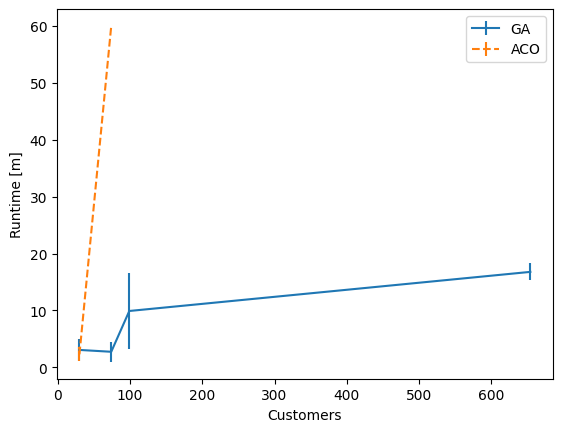

In [44]:
study_mapping = {
    30 : "B-n31-k5",
    74 : "tai75a",
    99 : "tai100a",
    654 : "X-n655-k131"
}
as_customers = []
as_runtime = []
as_error = []
ga_customers = []
ga_runtime = []
ga_error = []

for c, ds in study_mapping.items():
    try:
        as_st = optuna.load_study(study_name=f"as_{ds}", storage=f"sqlite:///as_{ds}.db")
        as_customers.append(c)
        as_runtime.append(np.mean([x.duration.total_seconds() / 60 for x in as_st.get_trials() if not x.duration is None and x.state == optuna.trial.TrialState.COMPLETE]))
        as_error.append(np.std([x.duration.total_seconds() / 60  for x in as_st.get_trials() if not x.duration is None and x.state == optuna.trial.TrialState.COMPLETE]))
    except KeyError:
        pass


ga_st = optuna.load_study(study_name=f"ga_B-n31-k5", storage=f"sqlite:///ga_B-n31-k5.db")
ga_customers.append(30)
ga_runtime.append(np.mean([x.duration.total_seconds() / 60 for x in ga_st.get_trials() if not x.duration is None and x.state == optuna.trial.TrialState.COMPLETE]))
ga_error.append(np.std([x.duration.total_seconds() / 60 for x in ga_st.get_trials() if not x.duration is None and x.state == optuna.trial.TrialState.COMPLETE]))

ga_customers.append(74)
ga_runtime.append(60)
ga_error.append(0)

fig, ax = plt.subplots()
ax.errorbar(as_customers, as_runtime, yerr=as_error, label="GA")
ax.errorbar(ga_customers, ga_runtime, yerr=ga_error, label="ACO", linestyle='dashed')
ax.set_xlabel("Customers")
ax.set_ylabel("Runtime [m]")
ax.legend()

fig.savefig("./plots/vrp/runtime.pdf")
fig.savefig("./plots/vrp/runtime.png")

In [41]:
ga_runtime

[2.290366127777778, 60]